Generate descwl-shear-sims images (either write them to a local directory or define a batch locally in this notebook):

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from descwl_shear_sims.galaxies import FixedGalaxyCatalog
from descwl_shear_sims.galaxies import WLDeblendGalaxyCatalog
from descwl_shear_sims.stars import StarCatalog, make_star_catalog
from descwl_shear_sims.sim import make_sim
from descwl_shear_sims.psfs import make_fixed_psf
from descwl_shear_sims.psfs import make_ps_psf
from descwl_shear_sims.sim import get_se_dim
from descwl_shear_sims.layout.layout import Layout
from tqdm import tqdm
import galsim

In [2]:
# path to DC2 star catalog
# See "Getting the Simulation Input Data Section" on https://github.com/LSSTDESC/descwl-shear-sims 
os.environ['CATSIM_DIR'] = '/data/scratch/taodingr/lsst_stack/descwl-shear-sims/notebooks/catsim' 

In [9]:
def filter_bright_stars(star_catalog, mag_threshold=18, band='r'):
    """
    Filter out bright stars at given magnitude threshold in a given band
    """
    if star_catalog is None:
        return None
    
    n_original = len(star_catalog)
    
    star_data = star_catalog._star_cat
    current_indices = star_catalog.indices
    
    mag_column = f'{band}_ab'
    if mag_column not in star_data.dtype.names:
        available_bands = [col.replace('_ab', '') for col in star_data.dtype.names if '_ab' in col]
        if available_bands:
            band = available_bands[0]
            mag_column = f'{band}_ab'
        else:
            print(f"ERROR: No magnitude columns found!")
            return star_catalog
    
    magnitudes = star_data[mag_column][current_indices]
    
    keep_mask = np.isfinite(magnitudes) & (magnitudes >= mag_threshold)
    n_kept = np.sum(keep_mask)
    n_removed = n_original - n_kept
    
    if n_kept == 0:
        print("WARNING: All stars would be removed! Using original catalog.")
        return star_catalog
    
    if n_removed == 0:
        print("INFO: No bright stars found to remove.")
        return star_catalog
    
    filtered_catalog = StarCatalog(
        rng=star_catalog.rng,
        layout='random',  
        coadd_dim=600,    
        buff=0,           
        pixel_scale=0.2,  
        density=n_kept,   
    )
    
    filtered_catalog._star_cat = star_catalog._star_cat
    filtered_catalog.shifts_array = star_catalog.shifts_array[keep_mask]
    filtered_catalog.indices = star_catalog.indices[keep_mask]
    filtered_catalog.density = star_catalog.density * (n_kept / n_original)
    
    return filtered_catalog


In [10]:

def create_psf(psf_type="gauss", psf_fwhm=0.8, variable_psf=False, variation_factor=0.1, se_dim=5000, rng_seed=42):
    """Create PSF object based on parameters"""
    rng = np.random.RandomState(rng_seed)
    
    if variable_psf:
        return make_ps_psf(rng=rng, dim=se_dim, variation_factor=variation_factor)
    else:
        if psf_type == "gauss":
            return make_fixed_psf(psf_type=psf_type) 
        elif psf_type == "moffat":  
            return make_fixed_psf(psf_type=psf_type, psf_fwhm=psf_fwhm)


In [11]:
def get_psf_param(psf_obj, return_image=True, psf_size=32, center_pos=None):
    """
    Extract PSF parameters AND the PSF image array for different PSF types
    """
    
    if center_pos is None:
        if hasattr(psf_obj, '_im_cen'):
            # Variable PSF  
            center_pos = (psf_obj._im_cen, psf_obj._im_cen)
            x_pixels = np.arange(psf_obj._tot_width)
            y_pixels = np.arange(psf_obj._tot_width)
        else:
            # Fixed PSF (Gauss/Moffat) 
            center_pos = (psf_size / 2.0, psf_size / 2.0)
            x_pixels = np.arange(psf_size)
            y_pixels = np.arange(psf_size)
    else:
        if hasattr(psf_obj, '_tot_width'):
            x_pixels = np.arange(psf_obj._tot_width)
            y_pixels = np.arange(psf_obj._tot_width)
        else:
            x_pixels = np.arange(psf_size)
            y_pixels = np.arange(psf_size)

    X, Y = np.meshgrid(x_pixels, y_pixels, indexing='ij')
    
    if hasattr(psf_obj, '_tot_width'):
        # Variable PSF 
        psf_image = psf_obj.drawImage()
    else:
        # Fixed PSF 
        psf_image = psf_obj.drawImage(scale=0.2, nx=psf_size, ny=psf_size)
    
    # Convert to numpy array
    psf_array = psf_image.array
    
    if return_image:
        return {
            'center_pos': center_pos,
            'coordinates': (X, Y),
            'psf_image': psf_array,
            'psf_object': psf_obj
        }
    else:
        return {
            'center_pos': center_pos,
            'coordinates': (X, Y),
            'psf_object': psf_obj
        }

In [12]:
def generate_single_image_catalog(rng, psf, layout, shifts, g1, g2, mag, hlr, morph, catalog_type,
    select_observable, select_lower_limit, select_upper_limit, coadd_dim, buff, pixel_scale, sep, bands, 
    noise_factor, dither, dither_size, rotate, cosmic_rays, bad_columns, star_bleeds, draw_bright,
    generate_star, star_config, apply_star_filter, star_filter_mag, star_filter_band
    ):
    """
    Generate one catalog and image 
    """
    if catalog_type == 'wldeblend':
        galaxy_catalog = WLDeblendGalaxyCatalog(
            rng=rng,
            coadd_dim=coadd_dim,
            buff=buff,
            layout=layout,
            sep=sep,
            select_observable=select_observable,
            select_lower_limit=select_lower_limit,
            select_upper_limit=select_upper_limit
        )
        
        galaxy_catalog.shifts_array = shifts
        num = len(galaxy_catalog.shifts_array)
        galaxy_catalog.indices = galaxy_catalog.rng.randint(
            0,
            galaxy_catalog._wldeblend_cat.size,
            size=num,
        )
        galaxy_catalog.angles = galaxy_catalog.rng.uniform(low=0, high=360, size=num)
        magnitude = galaxy_catalog._wldeblend_cat[galaxy_catalog.indices]["i_ab"]
    else:
        galaxy_catalog = FixedGalaxyCatalog(
            rng=rng,
            coadd_dim=coadd_dim,
            buff=buff,
            layout=layout,
            mag=mag,
            hlr=hlr,
            morph=morph,
            pixel_scale=pixel_scale,
            sep=sep
        )

        galaxy_catalog.shifts_array = shifts
        magnitude = []

    if generate_star:
        star_catalog = make_star_catalog(
            rng=rng,  
            coadd_dim=coadd_dim,
            buff=buff,
            pixel_scale=pixel_scale,
            star_config=star_config
        )
        
        # Apply filtering if requested
        if apply_star_filter:
            star_catalog = filter_bright_stars(
                star_catalog, 
                mag_threshold=star_filter_mag, 
                band=star_filter_band, 
            )

    if generate_star:
        # generate galaxies and stars
        sim_data = make_sim(
            rng=rng,
            galaxy_catalog=galaxy_catalog,
            star_catalog=star_catalog,
            coadd_dim=coadd_dim,
            g1=g1,
            g2=g2,
            bands=bands,
            psf=psf,
            noise_factor=noise_factor,
            dither=dither,
            dither_size=dither_size,
            rotate=rotate,
            cosmic_rays=cosmic_rays,
            bad_columns=bad_columns,
            star_bleeds=star_bleeds,
            draw_bright=draw_bright,
        )    
    else:
        # only generate galaxies
        sim_data = make_sim(
            rng=rng,
            galaxy_catalog=galaxy_catalog,
            coadd_dim=coadd_dim,
            g1=g1,
            g2=g2,
            bands=bands,
            psf=psf,
            noise_factor=noise_factor,
            dither=dither,
            dither_size=dither_size,
            rotate=rotate,
            cosmic_rays=cosmic_rays,
            bad_columns=bad_columns,
            star_bleeds=star_bleeds,
        )    

    truth = sim_data['truth_info']
    image_x_positions = truth['image_x']
    image_y_positions = truth['image_y']

    x_pos_copy = np.array(image_x_positions, copy=True)
    y_pos_copy = np.array(image_y_positions, copy=True)
    
    positions_tensor = torch.stack([
        torch.from_numpy(x_pos_copy),
        torch.from_numpy(y_pos_copy)
    ], dim=1).float()
    
    M = len(image_x_positions)

    n_bands = len(bands)
    first_band = bands[0]
    h, w = sim_data['band_data'][first_band][0].image.array.shape
    
    image_tensor = torch.zeros(n_bands, h, w, dtype=torch.float32)
    
    for i, band in enumerate(bands):
        image_np = sim_data['band_data'][band][0].image.array
        image_tensor[i] = torch.from_numpy(image_np.copy())
    
    return image_tensor, positions_tensor, M, magnitude


In [13]:
def generate_images_sequential(
    num_images, seed, shear_setting, layout_name, coadd_dim, buff, pixel_scale, density,
    mag, hlr, morph, catalog_type, select_observable, select_lower_limit, select_upper_limit, sep,
    psf_type, variable_psf, variation_factor, bands, noise_factor, dither, dither_size, rotate,
    cosmic_rays, bad_columns, star_bleeds, draw_bright, generate_star, star_config, apply_star_filter,
    star_filter_mag, star_filter_band, save_psf_param, psf_size
    ):
    """
    Generate images sequentially with all parameters listed
    
    Parameters:
    -----------
    num_images : int
        Number of images to generate
    seed : int
        Random seed
    shear_setting : str
        'const' for constant shear, 'vary' for variable shear
    layout_name : str
        Layout type ('random', 'grid', etc.)
    coadd_dim : int
        Image dimension before cropping
    buff : int
        Buffer around image edges
    pixel_scale : float
        Pixel scale in arcsec/pixel
    density : int
        Galaxy density per image
    mag : float
        Galaxy magnitude (for fixed catalog)
    hlr : float
        Half-light radius (for fixed catalog)
    morph : str
        Galaxy morphology ('exp', 'dev', etc.)
    catalog_type : str
        'fixed' or 'wldeblend'
    select_observable : bool
        Whether to select observable galaxies
    select_lower_limit : float
        Lower magnitude limit for selection
    select_upper_limit : float
        Upper magnitude limit for selection
    sep : int
        Minimum separation between objects
    psf_type : str
        PSF type ('gauss', 'moffat')
    variable_psf : bool
        Whether to use variable PSF
    variation_factor : float
        PSF variation factor (if variable_psf=True)
    bands : list
        List of bands to simulate
    noise_factor : float
        Noise scaling factor
    dither : bool
        Whether to apply dithering
    dither_size : int
        Dither size in pixels
    rotate : bool
        Whether to apply rotation
    cosmic_rays : bool
        Whether to add cosmic rays
    bad_columns : bool
        Whether to add bad columns
    star_bleeds : bool
        Whether to add star bleeds
    draw_bright : bool
        Whether to draw bright objects
    generate_star : bool
        Whether to generate stars
    apply_star_filter : bool
        Whether to filter bright stars
    star_filter_mag : float
        Magnitude threshold for star filtering
    star_filter_band : str
        Band for star magnitude filtering
    save_psf_param : bool
        Whether to save PSF parameters
    psf_size : int
        Size of PSF image to save
    
    Returns:
    --------
    images : list
        Image tensor of shape [num_images, n_bands, height, width]
    catalogs : list  
        List of catalog dictionaries
    psf_params : list or None
        List of PSF parameters (if save_psf_param=True)
    """
    
    print(f"Generating {num_images} images sequentially...")
    print(f"Bands: {bands}")
    print(f"Galaxy density: {density}")
    print(f"Generate stars: {generate_star}")

    
    # Setup
    rng = np.random.RandomState(seed)
    
    # Pre-generate shear values
    if shear_setting == "const":
        const_shear = 0.05
        g1 = np.full(num_images, const_shear, dtype=np.float32)
        g2 = np.full(num_images, const_shear, dtype=np.float32)
        print(f"Using constant shear: g1={const_shear}, g2={const_shear}")
    elif shear_setting == "vary":
        rng_shear = np.random.RandomState(seed + 1000)
        g1 = np.clip(rng_shear.normal(0.0, 0.015, num_images), -0.05, 0.05).astype(np.float32)
        g2 = np.clip(rng_shear.normal(0.0, 0.015, num_images), -0.05, 0.05).astype(np.float32)
    
    layout = Layout(
        layout_name=layout_name,
        coadd_dim=coadd_dim,
        pixel_scale=pixel_scale,
        buff=buff
    )
    shifts = layout.get_shifts(rng, density=density)
    
    se_dim = get_se_dim(coadd_dim=coadd_dim, rotate=rotate)
    psf = create_psf(
        psf_type=psf_type, 
        psf_fwhm=0.8, 
        variable_psf=variable_psf, 
        variation_factor=variation_factor, 
        se_dim=se_dim, 
        rng_seed=seed
    )
    print(f"PSF: {psf_type}, variable={variable_psf}")
    
    # Storage for results
    n_bands = len(bands)
    images_tensor = torch.zeros(num_images, n_bands, 2048, 2048, dtype=torch.float32)
    catalogs = []
    psf_params = []
    
    # Generate images
    for i in tqdm(range(num_images), desc="Generating images"):
        # Generate single image
        image_tensor, positions_tensor, M, magnitude = generate_single_image_catalog(rng=rng, psf=psf, layout=layout, shifts=shifts, 
        g1=g1[i], g2=g2[i], mag=mag, hlr=hlr, morph=morph, catalog_type=catalog_type,
        select_observable=select_observable, select_lower_limit=select_lower_limit, select_upper_limit=select_upper_limit, 
        coadd_dim=coadd_dim, buff=buff, pixel_scale=pixel_scale, sep=sep, bands=bands, 
        noise_factor=noise_factor, dither=dither, dither_size=dither_size, rotate=rotate, 
        cosmic_rays=cosmic_rays, bad_columns=bad_columns, star_bleeds=star_bleeds, draw_bright=draw_bright,
        generate_star=generate_star, star_config=star_config, apply_star_filter=apply_star_filter, 
        star_filter_mag=star_filter_mag, star_filter_band=star_filter_band
        )
        
        crop_size = 2048
        if crop_size < image_tensor.shape[1]:
            H, W = image_tensor.shape[1], image_tensor.shape[2]
            start_h = (H - crop_size) // 2
            start_w = (W - crop_size) // 2
            image_tensor = image_tensor[:, start_h:start_h + crop_size, start_w:start_w + crop_size]
        
        # Store results
        images_tensor[i] = image_tensor
        catalogs.append({
            'positions': positions_tensor,
            'n_sources': M,
            'g1': g1[i],
            'g2': g2[i],
            'magnitude': magnitude
        })
        
        # Get PSF parameters if requested
        if save_psf_param:
            psf_param = get_psf_param(psf, return_image=True, psf_size=psf_size)
            psf_params.append(psf_param)
    
    print(f"Generated {num_images} images successfully")
    
    return images_tensor, catalogs, psf_params if save_psf_param else None
    

In [14]:
# Data generation settings  
num_data = 20        # number of images to generate
seed = 1234

# VARIABLE PSF setting
variable_psf = False
variation_factor = 1.0
save_psf_param = True
psf_size = 64

# FIXED PSF setting
psf_type = "moffat"          # "moffat" or "gauss"
morph = 'exp'                

# other setting
mag = 17.0                   # 17.0 is default
hlr = 0.5                    # 0.5 is default
pixel_scale = 0.2            # 0.2 is default
layout_name = 'random'       # 'random' or 'grid'
coadd_dim = 2550             # without rotation, image dim is coadd_dim + 1
buff = 0                     # 0 is default
sep = 9.5                    # null is default
bands = ['r', 'i', 'z']      # ['i'] is default
noise_factor = 1             # 0.58 is default
dither = False               # False is default
dither_size = 0.5            # 0.5 is default
rotate = False               # False is default
cosmic_rays = False          # Set to True to add cosmic rays
bad_columns = False          # Set to True to add bad columns
shear_setting = 'vary'       # vary or const

density = 10                 # GALAXY density: per square arcmin, 80 is default  

setting = 'WLD_80_star_max_100_2000_with_filter_psf_256'

catalog_type = 'wldeblend'   # 'wldeblend' or 'fixed'   
select_observable = 'i_ab'   # column name in the WLDEBlend catalog
select_lower_limit = None
select_upper_limit = 27 
n_tiles_per_side = 1

# Star configuration
generate_star = True # set to false to disable star catalog
star_bleeds = True 

# star_config = {'max_density': 10} 
star_config = {'density': 5} 

star_filter = True
star_filter_mag = 18.0
star_filter_band = 'r'

draw_bright = False


In [15]:
images, catalogs, psf_params = generate_images_sequential(
    num_images=num_data, seed=seed, shear_setting=shear_setting, layout_name=layout_name, coadd_dim=coadd_dim, buff=buff, pixel_scale=pixel_scale, density=density,
    mag=mag, hlr=hlr, morph=morph, catalog_type=catalog_type, select_observable=select_observable, select_lower_limit=select_lower_limit, select_upper_limit=select_upper_limit, sep=sep,
    psf_type=psf_type, variable_psf=variable_psf, variation_factor=variation_factor, bands=bands, noise_factor=noise_factor, dither=dither, dither_size=dither_size, rotate=rotate,
    cosmic_rays=cosmic_rays, bad_columns=bad_columns, star_bleeds=star_bleeds, draw_bright=draw_bright, generate_star=generate_star, star_config=star_config, apply_star_filter=star_filter,
    star_filter_mag=star_filter_mag, star_filter_band=star_filter_band, save_psf_param=save_psf_param, psf_size=psf_size
    )

Generating 20 images sequentially...
Bands: ['r', 'i', 'z']
Galaxy density: 10
Generate stars: True
no coadd_scale or se_scale. Assume they are the same
PSF: moffat, variable=False


Generating images: 100%|██████████| 20/20 [01:21<00:00,  4.09s/it]

Generated 20 images successfully


In [27]:
# Uncomment to save the generated images, catalogs, and PSF parameters 
# torch.save(images, 'path_to_save/images.pt')
# torch.save(catalogs, 'path_to_save/catalogs.pt')
# torch.save(psf_params, 'path_to_save/psf_params.pt') 

Run AnaCal:

In [16]:
import anacal
from scipy.stats import linregress

In [17]:
def convert_for_anacal(catalogs, psf_params):
    num_images = len(catalogs)
    
    # Create 2D tensors [num_images, 1] - NOT 1D!
    g1_values = torch.tensor([[cat['g1']] for cat in catalogs], dtype=torch.float32)
    g2_values = torch.tensor([[cat['g2']] for cat in catalogs], dtype=torch.float32)
    
    anacal_catalog = {
        'shear_1': g1_values,  # Shape: [num_images, 1]
        'shear_2': g2_values,  # Shape: [num_images, 1]
    }
    
    # Convert PSF (same as before)
    anacal_psf = []
    for psf_param in psf_params:
        psf_image = psf_param['psf_image']
        if isinstance(psf_image, torch.Tensor):
            psf_image = psf_image.numpy()
        anacal_psf.append({'psf_image': psf_image.astype(np.float64)})
        
    return anacal_catalog, anacal_psf

In [18]:
def anacal_estimate(image, psf, catalog, npix):
    catalog, psf = convert_for_anacal(catalog, psf)
    true_shear1 = catalog['shear_1'].squeeze()
    true_shear2 = catalog['shear_2'].squeeze()

    fpfs_config = anacal.fpfs.FpfsConfig(
        npix=npix,
        sigma_arcsec=0.52,
    )

    mag_zero = 30.0
    pixel_scale = 0.2
    noise_variance = 0.23**2.0
    noise_array = None
    detection = None

    band = 0  # r-band

    est_shear1 = torch.zeros(len(image))
    est_shear2 = torch.zeros(len(image))

    for i in range(len(image)):
        gal_array = image[i,band]
        psf_array = psf[i]['psf_image']

        out = anacal.fpfs.process_image(
            fpfs_config=fpfs_config,
            mag_zero=mag_zero,
            gal_array=gal_array,
            psf_array=psf_array,
            pixel_scale=pixel_scale,
            noise_variance=noise_variance,
            noise_array=noise_array,
            detection=detection,
        )

        e1 = out["fpfs_w"] * out["fpfs_e1"]
        e1g1 = out["fpfs_dw_dg1"] * out["fpfs_e1"] + out["fpfs_w"] * out["fpfs_de1_dg1"]

        est_shear1[i] = np.sum(e1) / np.sum(e1g1)

        e2 = out["fpfs_w"] * out["fpfs_e2"]
        e2g2 = out["fpfs_dw_dg2"] * out["fpfs_e2"] + out["fpfs_w"] * out["fpfs_de2_dg2"]
        
        est_shear2[i] = np.sum(e2) / np.sum(e2g2)

    return est_shear1, est_shear2, true_shear1, true_shear2


In [19]:
est_shear1, est_shear2, true_shear1, true_shear2 = anacal_estimate(images, psf_params, catalogs, 64)

Plot scatterplots:

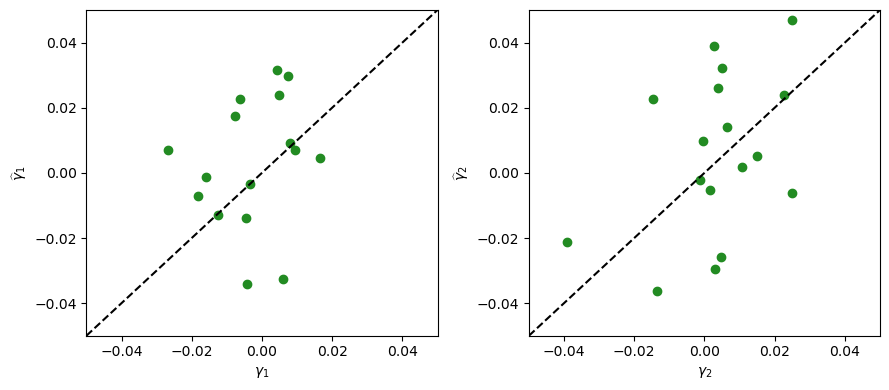

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (9, 4))

_ = ax[0].scatter(true_shear1, est_shear1, color = 'forestgreen')
_ = ax[0].axline((0,0), slope = 1, linestyle = 'dashed', color = 'black')
_ = ax[0].set_xlabel("$\gamma_1$")
_ = ax[0].set_ylabel("$\widehat{\gamma}_1$")
_ = ax[0].set_xlim(-0.05, 0.05)
_ = ax[0].set_ylim(-0.05, 0.05)

_ = ax[1].scatter(true_shear2, est_shear2, color = 'forestgreen')
_ = ax[1].axline((0,0), slope = 1, linestyle = 'dashed', color = 'black')
_ = ax[1].set_xlabel("$\gamma_2$")
_ = ax[1].set_ylabel("$\widehat{\gamma}_2$")
_ = ax[1].set_xlim(-0.05, 0.05)
_ = ax[1].set_ylim(-0.05, 0.05)

_ = fig.tight_layout()